In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mojtababc","key":"66b8adbe9dc9db8706c2442d6ed423b3"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install kaggle
!pip install numpy
!pip install opencv-python-headless
!pip install tensorflow
!pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.1 MB/s eta 0:00:00


In [17]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi

In [5]:
api = KaggleApi()
api.authenticate()

# Define the dataset
dataset = 'tawsifurrahman/covid19-radiography-database'

# Download the dataset
api.dataset_download_files(dataset, path='./data', unzip=True)

# Load and preprocess images
def load_images(data_dir, img_size):
    categories = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    images = []
    labels = []
    label_map = {category: idx for idx, category in enumerate(categories)}

    for category in categories:
        path = os.path.join(data_dir, category, 'images')
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(label_map[category])

    return np.array(images), np.array(labels)



Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


In [6]:
data_dir = './data/COVID-19_Radiography_Dataset/'
img_size = 224
X, y = load_images(data_dir, img_size)

# Normalize images
X = X / 255.0


In [18]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Data augmentation for validation (just rescaling)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes: COVID, Lung_Opacity, Normal, Viral Pneumonia

# Model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)




In [19]:
print('plotting')

# Train
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping])


plotting
Epoch 1/10
530/530 [==============================] - 1123s 2s/step - loss: 0.6056 - accuracy: 0.7769 - val_loss: 1.3864 - val_accuracy: 0.2558
Epoch 2/10
530/530 [==============================] - 1094s 2s/step - loss: 0.3886 - accuracy: 0.8583 - val_loss: 2.7284 - val_accuracy: 0.3099
Epoch 3/10
530/530 [==============================] - 1071s 2s/step - loss: 0.3299 - accuracy: 0.8783 - val_loss: 0.7281 - val_accuracy: 0.6846
Epoch 4/10
530/530 [==============================] - 1080s 2s/step - loss: 0.3093 - accuracy: 0.8903 - val_loss: 0.5850 - val_accuracy: 0.7845
Epoch 5/10
530/530 [==============================] - 1062s 2s/step - loss: 0.2782 - accuracy: 0.8994 - val_loss: 0.9649 - val_accuracy: 0.6003
Epoch 6/10
530/530 [==============================] - 1068s 2s/step - loss: 0.2666 - accuracy: 0.9049 - val_loss: 1.8446 - val_accuracy: 0.4954
Epoch 7/10
530/530 [==============================] - 1084s 2s/step - loss: 0.2526 - accuracy: 0.9098 - val_loss: 0.6684 - val_

plotting


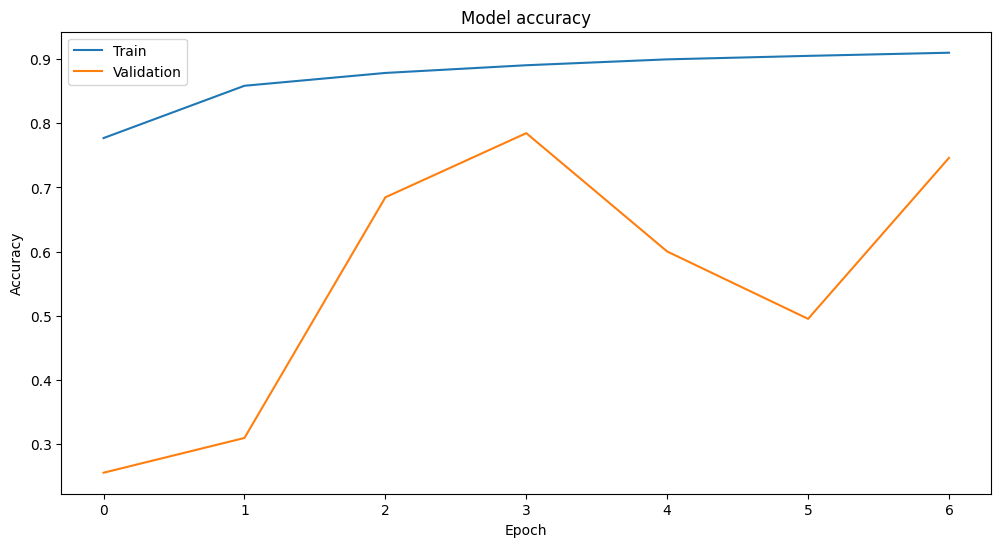

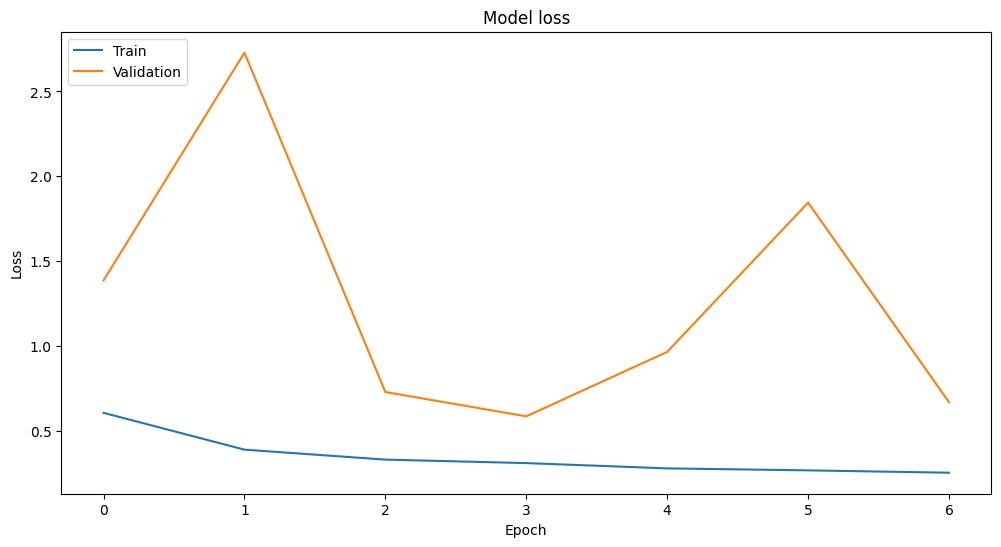

plotting done


In [20]:

print('plotting')
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print("plotting done")